To avoid contamination from initialization artifacts, firing rates were computed after discarding an initial transient period (first 200 ms). This ensures that all reported quantities reflect steady-state network dynamics rather than nonstationary behavior induced by arbitrary initial conditions.


In [1]:
import importlib
import model
import numpy as np
importlib.reload(model)
from model.model import network
from model.model import UA_PER_CM2_TO_SI

In [2]:
res= network(
    dt_ms=0.05,
    T_ms=10000.0,
    rng_seed=0,
    gNI_mS_cm2=0.008,
    gEI_mS_cm2=0.08,
    gNE_mS_cm2=0.008,
    gEE_mS_cm2=0.10,
    gIE_mS_cm2=0.25,
    gII_mS_cm2=0.10,
    Iapp_E_uAcm2=4.0,
    Iapp_I_uAcm2=0.0,
    alpha_n_per_ms=0.5
)

INFO       No numerical integration method specified for group 'S_EE', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'S_EI', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'S_IE', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'S_II', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]


In [3]:
# analysis
lfp = res["lfp"]
t   = res["t_lfp"]

In [2]:
def compute_mean_power(lfp, dt):
    fs=1.0/(dt * 1e-3)
    samples_per_bin = int(1.0 * fs)
    lfp_bins = [
        lfp[i*samples_per_bin:(i+1)*samples_per_bin]
        for i in range(len(lfp) // samples_per_bin)
    ]
    freqs = np.fft.rfftfreq(samples_per_bin, d=1/fs)

    power_bins = []
    for segment in lfp_bins:
        segment = segment - segment.mean()  # DC removal
        fft_vals = np.fft.rfft(segment)
        power = np.abs(fft_vals)**2
        power_bins.append(power)

    mean_power = np.mean(power_bins, axis=0)

    return mean_power,freqs

In [3]:
g_values = [0.0, 0.006, 0.012, 0.018, 0.024, 0.054]
IappI_values = [0.0, 0.5]   # test two regimes

all_results = {}

for IappI in IappI_values:
    peak_powers = []
    peak_freqs  = []

    for gg in g_values:
        res = network(
            dt_ms=0.05,
            T_ms=10000.0,
            rng_seed=0,
            gNI_mS_cm2=gg,
            Iapp_I_uAcm2=IappI,
            alpha_n_per_ms=0.5
        )

        lfp = res["lfp"]
        dt  = res["params"]["dt_ms"]

        freqs, mean_power = compute_mean_power(lfp, dt)

        # restrict peak search to gamma band
        gamma = (freqs >= 20) & (freqs <= 80)
        idx = np.argmax(mean_power[gamma])
        f0  = freqs[gamma][idx]

        band = (freqs >= f0 - 3) & (freqs <= f0 + 3)
        P0   = np.mean(mean_power[band])

        peak_freqs.append(float(f0))
        peak_powers.append(float(P0))

    all_results[IappI] = (peak_freqs, peak_powers)



INFO       No numerical integration method specified for group 'S_EE', using method 'euler' (took 0.02s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'S_EI', using method 'euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'S_IE', using method 'exact' (took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'S_II', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]


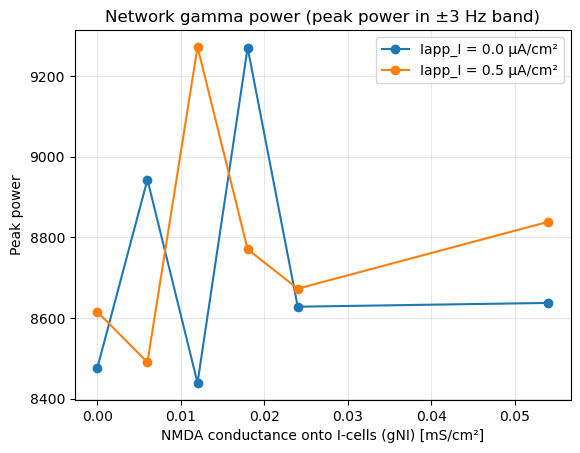

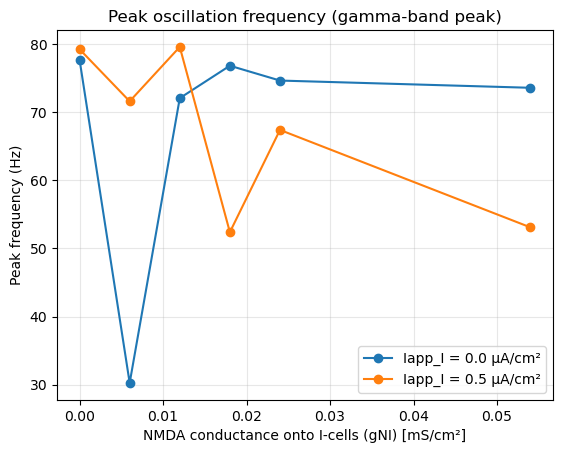

In [4]:
import matplotlib.pyplot as plt

g_values = [0.0, 0.006, 0.012, 0.018, 0.024, 0.054]  # same order as in the sweep

# ---- Plot peak power vs gNI (one curve per IappI) ----
plt.figure()
for IappI, (peak_freqs, peak_powers) in all_results.items():
    plt.plot(g_values, peak_powers, marker="o", label=f"Iapp_I = {IappI} µA/cm²")

plt.title("Network gamma power (peak power in ±3 Hz band)")
plt.xlabel("NMDA conductance onto I-cells (gNI) [mS/cm²]")
plt.ylabel("Peak power")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- Plot peak frequency vs gNI (one curve per IappI) ----
plt.figure()
for IappI, (peak_freqs, peak_powers) in all_results.items():
    plt.plot(g_values, peak_freqs, marker="o", label=f"Iapp_I = {IappI} µA/cm²")

plt.title("Peak oscillation frequency (gamma-band peak)")
plt.xlabel("NMDA conductance onto I-cells (gNI) [mS/cm²]")
plt.ylabel("Peak frequency (Hz)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


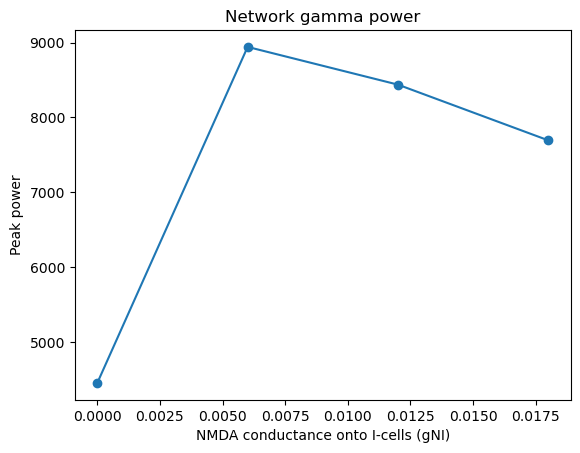

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(g, peak_powers, 'o-')
plt.xlabel("NMDA conductance onto I-cells (gNI)")
plt.ylabel("Peak power")
plt.title("Network gamma power")
plt.show()


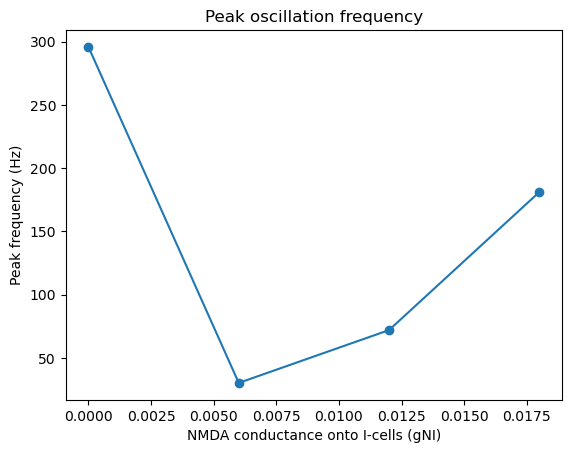

In [7]:
plt.figure()
plt.plot(g, peak_freqs, 'o-')
plt.xlabel("NMDA conductance onto I-cells (gNI)")
plt.ylabel("Peak frequency (Hz)")
plt.title("Peak oscillation frequency")
plt.show()
